## Baixando o dataset via cURL

In [ ]:
# Baixa o dataset heartbeat do Kaggle via cURL
!curl -L -o ./heartbeat.zip\
  https://www.kaggle.com/api/v1/datasets/download/shayanfazeli/heartbeat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 98.8M  100 98.8M    0     0  18.8M      0  0:00:05  0:00:05 --:--:-- 20.8M


Descompacitando o dataset e salvando ele na pasta `datasets`

In [ ]:
# Cria a pasta e extrai o ZIP baixado para ./datasets
!mkdir datasets & unzip heartbeat.zip -d ./datasets

Archive:  heartbeat.zip
replace ./datasets/mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: mkdir: cannot create directory ‘datasets’: File exists
yes
  inflating: ./datasets/mitbih_test.csv  
replace ./datasets/mitbih_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: ./datasets/mitbih_train.csv  yes

replace ./datasets/ptbdb_abnormal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: ./datasets/ptbdb_abnormal.csv  
replace ./datasets/ptbdb_normal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./datasets/ptbdb_normal.csv  


Importando as bibliotecas necessarias

In [52]:
# Importa bibliotecas usadas em pré-processamento, clustering, visualização e rede neural
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

## Carregando os dados
O dataset já vem com o conjunto de treino e de testes.

Aqui carregamos os dados com pandas, transformando ambos de `Dataframes`



In [ ]:
# Lendo os CSVs de treino e teste do MIT-BIH
train_df = pd.read_csv("./datasets/mitbih_train.csv", header=None)
test_df = pd.read_csv("./datasets/mitbih_test.csv", header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Checa o formato (linhas x colunas) do conjunto de treino
train_df.shape

(87554, 188)

Como não há header, cada coluna recebe índices numéricos automáticos.

Colunas 0–186 → Features

Coluna 187 → Classe

Separação de treino/teste:

In [39]:
# Separa features (colunas 0-186) e rótulos (coluna 187) para treino e teste
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

# Teste
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

In [40]:
# Visualiza a matriz de features de treino para conferência
X_train

array([[0.97794116, 0.92647058, 0.68137252, ..., 0.        , 0.        ,
        0.        ],
       [0.96011394, 0.86324787, 0.46153846, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.65945947, 0.18648648, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.90612245, 0.62448978, 0.59591836, ..., 0.        , 0.        ,
        0.        ],
       [0.85822785, 0.64556962, 0.84556961, ..., 0.        , 0.        ,
        0.        ],
       [0.90150636, 0.84588647, 0.80069524, ..., 0.        , 0.        ,
        0.        ]])

# Normalização dos dados
A normalização é fundamental porque:

* O K-Means é sensível à escala

* Redes neurais convergem mais rápido com entradas padronizadas

* Features de diferentes magnitudes podem dominar o agrupamento

O StandardScaler foi utilizado porque tanto o K-Means quanto o PCA(grafico que vamos fazer mais a frente) e a rede neural dependem diretamente da escala das features.

In [ ]:
# Normaliza features com StandardScaler para estabilizar modelos

# Instanciando StandScaler para normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 0.36354765,  0.75879683,  1.13240614, ..., -0.09259618,
        -0.08959366, -0.08793965],
       [ 0.28954748,  0.47376846,  0.16526879, ..., -0.09259618,
        -0.08959366, -0.08793965],
       [ 0.45511319, -0.44497542, -1.04479413, ..., -0.09259618,
        -0.08959366, -0.08793965],
       ...,
       [ 0.06543057, -0.60263006,  0.75645932, ..., -0.09259618,
        -0.08959366, -0.08793965],
       [-0.13337832, -0.50759535,  1.85477435, ..., -0.09259618,
        -0.08959366, -0.08793965],
       [ 0.04626936,  0.39549766,  1.65735418, ..., -0.09259618,
        -0.08959366, -0.08793965]])

# Tarefa 1 — Agrupamento Não Supervisionado com K-Means

Aqui fazemos o agrupamentos da das classes do dataset com K-Means.

O número de clusters k = 5 corresponde às classes reais do dataset.

In [42]:
# Ajusta o K-Means com 5 clusters correspondentes às classes
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

np.unique(clusters)

array([0, 1, 2, 3, 4], dtype=int32)

# Comparação entre clusters e os rótulos reais.
Aqui geramos uma tabela comparando os clusters  com os rotulos reais do dataset.

Essa tabela permite avaliar:

* Quais classes têm morfologia mais distinta

* Onde há sobreposição entre classes

* O impacto do desbalanceamento

In [43]:
# Compara cada cluster do K-Means com as classes reais via tabela de contingência
cluster_vs_label = pd.crosstab(clusters, y_train,
                               rownames=["Cluster (KMeans)"],
                               colnames=["Classe real"])
cluster_vs_label


Classe real,0.0,1.0,2.0,3.0,4.0
Cluster (KMeans),,,,,
0,38549,646,1452,471,1573
1,2702,33,1242,5,2148
2,18475,967,1285,157,386
3,2364,261,793,5,1
4,10381,316,1016,3,2323


# Redução de dimensionalidade com PCA para visualização

O PCA não foi usado como modelo, apenas como forma de visualizar como o K-Means agrupou os dados.


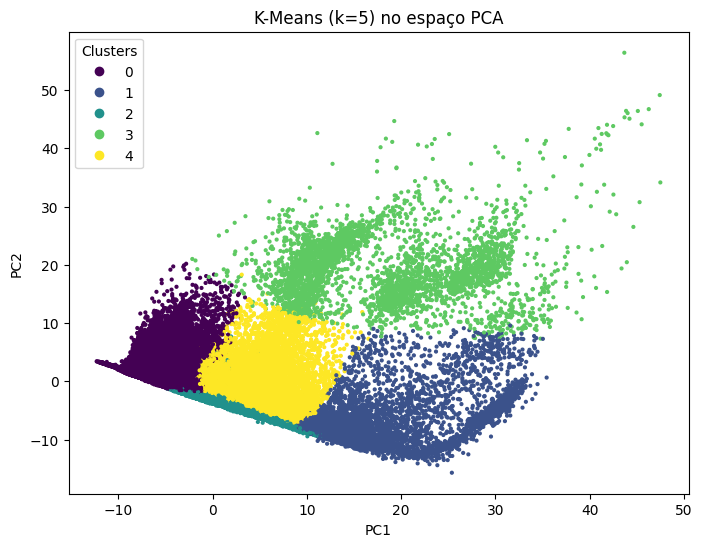

In [44]:
# Reduz para 2 dimensões com PCA e plota cores por cluster para visualização
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, s=4)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("K-Means (k=5) no espaço PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# O que os graficos nos mostra:

1 - Cluster roxo (classe 0):

* Forma um grupo compacto assim indica boa separação natural da classe normal.

2 - Clusters azul e verde:

* Sobreposição parcial, as classes 1 e 2 (supraventriculares e ventriculares) têm alta variabilidade morfológica.

3 - Clusters amarelo e ciano:

* Representam combinações de classes minoritárias (3 e 4) com ruído

* Mostram que batimentos raros não formam grupos bem definidos.


Com isso podemos responder a primeira pergunta.

"O que a análise da Tarefa 1 (K-Means) revelou sobre a distribuição de dados entre as 5
classes?"

A classe Normal (0) é a mais facilmente separável.

As classes 1 e 2 apresentam forte sobreposição assim explicando a dificuldade de classificação.

As classes 3 e 4 são dispersas e raras, por isso são de difícil agrupamento.

# Tarefa 2 — Classificação Supervisionada com Rede Neural

Aqui fazemos a preparação dos rótulos (labels) para serem utilizados pela rede neural.

In [45]:
# Converte rótulos numéricos para one-hot encoding esperado pela rede
num_classes = len(np.unique(y_train))

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)
y_train_cat

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

# Arquitetura da rede

Justificativa das escolhas:
1)Camadas densas(`Dense`): apropriadas para vetores fixos de features (tabular)
2)ReLU: acelera convergência
3)Dropout: reduz overfitting (importante pois as classes raras são pequenas)
4)Softmax: probabilidade para cada uma das 5 classes

In [46]:
# Define arquitetura densa com Dropout e compila otimizador/perda
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,645 (127.52 KB)

 Trainable params: 32,645 (127.52 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Treina a rede na base normalizada reservando 20% para validação
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    verbose=1,
)

Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 1.0000 - loss: 3.2392e-07 - val_accuracy: 0.1387 - val_loss: 27.3015
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: 3.4334e-07 - val_accuracy: 0.1387 - val_loss: 27.4007
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 1.7941e-07 - val_accuracy: 0.1387 - val_loss: 27.5116
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 2.7922e-07 - val_accuracy: 0.1387 - val_loss: 27.6598
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 1.6007e-07 - val_accuracy: 0.1387 - val_loss: 27.7712
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 1.6172e-07 - val_accuracy: 0.1387 - val_loss: 27.8943
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 1.9039e-07 - val_accuracy: 0.1387 - val_loss: 28.0669
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 1.00

In [56]:
# Avalia a rede no conjunto de teste e exibe acurácia
loss, acc = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Acurácia: {acc:.4f}")


Acurácia: 0.8276


# Matriz de Confusão

In [57]:
# Gera previsões e calcula a matriz de confusão das classes
y_pred_proba = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

cm = confusion_matrix(y_test, y_pred)
cm

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[18118,     0,     0,     0,     0],
       [  556,     0,     0,     0,     0],
       [ 1448,     0,     0,     0,     0],
       [  162,     0,     0,     0,     0],
       [ 1608,     0,     0,     0,     0]])

# Metricas escolhidas
Escolhemos as métricas Recall e F1-Score para um contexto mais clinico.

1)Recall das classes de arritmia (1, 2, 3, 4): representa quantas arritmias o modelo conseguiu detectar

2)F1-score (principalmente para classes desbalanceadas): equilíbrio entre precisão e recall



In [58]:
# Calcula precision/recall/F1 por classe e monta o relatório em DataFrame
target_names = [
    "0 - Normal (N)",
    "1 - Supraventricular (S)",
    "2 - Ventricular (V)",
    "3 - Fusão (F)",
    "4 - Desconhecido (Q)"
]

report_df = pd.DataFrame(classification_report(y_test, y_pred, target_names=target_names, zero_division=0.0, output_dict=True))
report_df.transpose()

,precision,recall,f1-score,support
0 - Normal (N),0.827608,1.000000,0.905674,18118.000000
1 - Supraventricular (S),0.000000,0.000000,0.000000,556.000000
2 - Ventricular (V),0.000000,0.000000,0.000000,1448.000000
3 - Fusão (F),0.000000,0.000000,0.000000,162.000000
4 - Desconhecido (Q),0.000000,0.000000,0.000000,1608.000000
accuracy,0.827608,0.827608,0.827608,0.827608
macro avg,0.165522,0.200000,0.181135,21892.000000
weighted avg,0.684935,0.827608,0.749543,21892.000000


# Segunda pergunta

"Para este problema, o que seria clinicamente pior: um Falso Positivo ou um Falso Negativo?
Justifique."

O falso negativo é significativamente mais perigoso, pois significa que um batimento arrítmico foi classificado como normal, logo em medicina, especialmente cardiologia, minimizar falsos negativos é prioridade.